In [127]:
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import copy

from matplotlib import style
style.use('seaborn')

In [337]:
random.seed(4)

In [371]:
def exprand(lambdr):
    return np.random.exponential(1/lambdr)

print(exprand(1/5))
print(np.random.exponential(1/5))

4.559182463046681
0.14212741709207205


In [372]:
a = []
b = []
for i in range(100000):
    a.append(np.random.exponential(5))
    b.append(exprand(1/5))
print(statistics.mean(a))
print(statistics.mean(b))

5.007806154648774
5.000102664268381


In [373]:
def exprand(lambdr):
    return -math.log(1.0 - random.random()) / lambdr

class Customer:
    def __init__(self, customer_id, check_in_time, time_to_process_this_customer):
        self.customer_id = customer_id  # номер человека
        self.check_in_time = check_in_time #время, в которое он придет
        self.time_to_process_this_customer = time_to_process_this_customer # время на обработку этого человека (+1 временное решение того, что 0 требуется на процесс)
        self.in_progress = False
        self.spent_time=time_to_process_this_customer
        
    def __repr__(self):
        return f'id={self.customer_id}, check_in= {self.check_in_time}, time_to_process_this_customer= {self.time_to_process_this_customer}'

# Обработчик
class Handler:
    def __init__(self, id):
        self.id = id
        self.powerness = 1.0
        self.tmp_powerness = self.powerness
        self.customer = None

    def process_customer(self, list_of_customers, mean_time_spent):  
        self.tmp_powerness = self.powerness
        tmp_powerness_ = self.tmp_powerness
        
        if self.customer:
            print(f'first, id= {self.id},tmp_powerness= {self.tmp_powerness}, \
                  time_to_process= {self.customer.time_to_process_this_customer},  \
                  tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
            tmp_powerness_-= self.customer.time_to_process_this_customer
            self.customer.time_to_process_this_customer -= self.tmp_powerness
            self.tmp_powerness = tmp_powerness_
            print(f'second, id= {self.id},tmp_powerness= {self.tmp_powerness}, \
                  time_to_process= {self.customer.time_to_process_this_customer},  \
                  tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
            if self.customer.time_to_process_this_customer <= 0:
                        mean_time_spent.append(self.customer.spent_time)
                        self.customer = None
        if list_of_customers is not None:
            for i in list_of_customers:
                if self.tmp_powerness > 0:
                    print(f'first, id= {self.id},tmp_powerness= {self.tmp_powerness},  \
                    time_to_process= {i.time_to_process_this_customer},  \
                    tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
                    tmp_powerness_-= i.time_to_process_this_customer
                    i.time_to_process_this_customer -= self.tmp_powerness
                    self.tmp_powerness = tmp_powerness_
                    print(f'second, id= {self.id},tmp_powerness= {self.tmp_powerness}, \
                    time_to_process= {i.time_to_process_this_customer}, \
                    tmp_powerness_= {tmp_powerness_},tmp_powerness= {self.tmp_powerness}')
                    if i.time_to_process_this_customer > 0:
                        self.customer = i
                        list_of_customers.remove(i)
                    if i.time_to_process_this_customer <= 0:
                        mean_time_spent.append(i.spent_time)
                        list_of_customers.remove(i)
                        
    def get_tmp_powerness(self):
        return self.tmp_powerness
    
    def get_powerness(self):
        return self.powerness

In [374]:
# Вeликий обрабатор!
class MainHandler:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        #self.number_of_customers = number_of_customers
        self.list_of_customers = []
        self.list_of_tmp_customers = []
        self.list_of_handlers = []
        self.number_of_customers_left  = 0
        self.customers_growth = []
        self.customers_all = 0
        self.mean_time_spent = []
        self.handler_load = []
        self.lambda_ = lambda_
        self.nu = nu
        
    def get_next(self, customer_id, check_in, nu):
        # Устанавливаем номер человека
        # время, через котрое он придет
        # и время, которое требуется на его обработку
        customer = Customer(customer_id, check_in, abs(exprand(nu)))
    
        return customer
    
    def generate_customers(self, steps):
        lost_time = steps  # оставшееся количество шагов == время для генерации

        customer_id = 0
        
        for i in range(steps):
            tmp = round(exprand(self.lambda_))
            print(tmp)
            if tmp == 0:
                tmp = 1
            
            for j in range(tmp):
                customer = self.get_next(customer_id, i, self.nu)
                print(customer)
                customer_id += 1
                self.list_of_customers.append(customer)

        #print("Number of customers:" + str(len(self.list_of_customers)))
        #for customer in self.list_of_customers:
            #print("check_in_time: "+str(customer.check_in_time) + " and time_to_process_this_customer:" + str(customer.time_to_process_this_customer))

    def start(self, steps):
        self.generate_customers(steps)
        
        for i in range(self.number_of_handlers):
            self.list_of_handlers.append(Handler(i))

        for i in range(steps):
            new_customers = [customer for customer in self.list_of_customers if customer.check_in_time == i]
            
            # save customers number
            self.customers_all += len(new_customers)
            self.customers_growth.append(self.customers_all)
            
            # обрабатываем людей
            for handler in self.list_of_handlers:
                handler.process_customer(new_customers, self.mean_time_spent)
        
            number_of_working_handlers = 0
            for handler in self.list_of_handlers:
                if handler.get_tmp_powerness() != handler.get_powerness():
                    number_of_working_handlers += 1
            
            self.handler_load.append(number_of_working_handlers)
            
            for j in new_customers:
                if j.in_progress is False:
                    self.number_of_customers_left+=1
                
            # продолжаем

    def clear(self):
        self.list_of_customers.clear()
        self.list_of_handlers.clear()
        self.number_of_customers_left  = 0
        self.customers_growth.clear()
        self.customers_all = 0
        self.mean_time_spent.clear()
        self.handler_load.clear()
        
    # statistics
    def get_customers(self):
        return self.list_of_customers
    
    # количество пришедших кастомеров с начала
    def get_customer_growth(self):
        return self.customers_growth
    
    # Среднее количество НОВЫХ заявок в системе
    def get_mean_customer_growth(self):
        return self.customers_all/len(self.customers_growth)
    
    # количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_handler_load(self):
        return self.handler_load
    
    # Среднее количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_mean_handler_load(self):
        sum_load = 0
        for load in self.handler_load:
            sum_load += load
        
        return sum_load/len(self.handler_load)
    
    # среднее время пребыания?
    def get_mean_time_spent(self):
        return statistics.mean(self.mean_time_spent)
    
    # вероятность отказа
    def get_deny_probability(self):
        return self.number_of_customers_left/self.customers_all

In [375]:
class Model:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.__handler = MainHandler(number_of_handlers, 1/lambda_, nu)
        self.__time = None
        
    def run(self):
        if self.__time is None or self.__handler is None:
            raise ValueError
        
        self.__handler.start(self.__time)
        
    def set_time(self, time):
        if time <= 0:
            raise ValueError
            
        self.__time = time
        
    def get_time(self):
        return self.__time
    
    def get_handler(self):
        return self.__handler
    
    def set_handler(self, handler):
        self.__handler = handler
    
    handler = property(get_handler, set_handler)
    time = property(get_time, set_time)


In [376]:
# Устанавливаем параметры
'''lambda_ = 1 # интенсивность
nu = 5 #пропускная способность
number_of_handlers = 5 # кол-во обработчиков
random.seed(42)

NUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'''




'lambda_ = 1 # интенсивность\nnu = 5 #пропускная способность\nnumber_of_handlers = 5 # кол-во обработчиков\nrandom.seed(42)\n\nNUMBER_OF_STEPS = 50*10 # общее количество шагов == времени'

In [377]:
model = Model(5, 10, 2)

In [388]:
#main = MainHandler(number_of_handlers, lambda_, nu)
#main.start(NUMBER_OF_STEPS)

model.time = 1000
model.run()

8
id=0, check_in= 0, time_to_process_this_customer= 0.01356419465805729
id=1, check_in= 0, time_to_process_this_customer= 1.2297318837501257
id=2, check_in= 0, time_to_process_this_customer= 1.38289546096392
id=3, check_in= 0, time_to_process_this_customer= 0.0505692786847207
id=4, check_in= 0, time_to_process_this_customer= 0.10852111032168578
id=5, check_in= 0, time_to_process_this_customer= 0.5917146774519628
id=6, check_in= 0, time_to_process_this_customer= 0.019421630900107453
id=7, check_in= 0, time_to_process_this_customer= 0.830446423330127
18
id=8, check_in= 1, time_to_process_this_customer= 1.4893208932940747
id=9, check_in= 1, time_to_process_this_customer= 0.034497582785324395
id=10, check_in= 1, time_to_process_this_customer= 0.8565792392370519
id=11, check_in= 1, time_to_process_this_customer= 0.014361034956196795
id=12, check_in= 1, time_to_process_this_customer= 0.2198463919896636
id=13, check_in= 1, time_to_process_this_customer= 1.430289983177751
id=14, check_in= 1, t

id=2213, check_in= 232, time_to_process_this_customer= 0.6395210320534103
id=2214, check_in= 232, time_to_process_this_customer= 0.18938270727356696
id=2215, check_in= 232, time_to_process_this_customer= 0.20192494403333033
id=2216, check_in= 232, time_to_process_this_customer= 0.13025905308574207
id=2217, check_in= 232, time_to_process_this_customer= 2.0222401905644283
id=2218, check_in= 232, time_to_process_this_customer= 0.23780278662640883
id=2219, check_in= 232, time_to_process_this_customer= 0.01344118786599915
id=2220, check_in= 232, time_to_process_this_customer= 0.8263571359568099
id=2221, check_in= 232, time_to_process_this_customer= 0.04883259998855841
id=2222, check_in= 232, time_to_process_this_customer= 0.891769290671422
id=2223, check_in= 232, time_to_process_this_customer= 0.5176346795384946
id=2224, check_in= 232, time_to_process_this_customer= 0.12165589155349568
9
id=2225, check_in= 233, time_to_process_this_customer= 0.1796451258936451
id=2226, check_in= 233, time_t

id=4051, check_in= 394, time_to_process_this_customer= 0.017103523560496336
id=4052, check_in= 394, time_to_process_this_customer= 1.0103274304031546
id=4053, check_in= 394, time_to_process_this_customer= 0.08854161669944131
id=4054, check_in= 394, time_to_process_this_customer= 1.961379178095084
id=4055, check_in= 394, time_to_process_this_customer= 0.07674418744928455
id=4056, check_in= 394, time_to_process_this_customer= 1.0473210510279978
id=4057, check_in= 394, time_to_process_this_customer= 0.5461930931492927
id=4058, check_in= 394, time_to_process_this_customer= 0.05063378795215875
id=4059, check_in= 394, time_to_process_this_customer= 0.07501953605874118
id=4060, check_in= 394, time_to_process_this_customer= 0.1447160593858458
id=4061, check_in= 394, time_to_process_this_customer= 0.19963398642644659
id=4062, check_in= 394, time_to_process_this_customer= 0.7368183524492229
id=4063, check_in= 394, time_to_process_this_customer= 0.2899876147684111
id=4064, check_in= 394, time_to_

id=5879, check_in= 565, time_to_process_this_customer= 0.6000653997198753
id=5880, check_in= 565, time_to_process_this_customer= 0.3612115468554944
id=5881, check_in= 565, time_to_process_this_customer= 0.07430542303407298
id=5882, check_in= 565, time_to_process_this_customer= 0.5962001348368329
id=5883, check_in= 565, time_to_process_this_customer= 0.3711435181695145
id=5884, check_in= 565, time_to_process_this_customer= 0.2650037103433222
id=5885, check_in= 565, time_to_process_this_customer= 1.1361217350980921
id=5886, check_in= 565, time_to_process_this_customer= 0.04701843951776885
id=5887, check_in= 565, time_to_process_this_customer= 0.19937648139003278
id=5888, check_in= 565, time_to_process_this_customer= 0.7177911143710811
id=5889, check_in= 565, time_to_process_this_customer= 0.48928922166023525
id=5890, check_in= 565, time_to_process_this_customer= 0.13487548371151822
id=5891, check_in= 565, time_to_process_this_customer= 1.2136691130262494
id=5892, check_in= 565, time_to_p

id=7707, check_in= 737, time_to_process_this_customer= 1.2467561044666091
id=7708, check_in= 737, time_to_process_this_customer= 0.7261658546058863
id=7709, check_in= 737, time_to_process_this_customer= 0.19223713093711145
id=7710, check_in= 737, time_to_process_this_customer= 0.04271776817530346
id=7711, check_in= 737, time_to_process_this_customer= 0.30675461154002276
id=7712, check_in= 737, time_to_process_this_customer= 1.044338511076922
id=7713, check_in= 737, time_to_process_this_customer= 0.8331137027229327
11
id=7714, check_in= 738, time_to_process_this_customer= 0.5218105929987842
id=7715, check_in= 738, time_to_process_this_customer= 0.13842089882216405
id=7716, check_in= 738, time_to_process_this_customer= 2.580738691820738
id=7717, check_in= 738, time_to_process_this_customer= 0.026685760184274033
id=7718, check_in= 738, time_to_process_this_customer= 0.061599141717760444
id=7719, check_in= 738, time_to_process_this_customer= 0.3304741924440225
id=7720, check_in= 738, time_

id=9522, check_in= 921, time_to_process_this_customer= 2.0680675916058036
id=9523, check_in= 921, time_to_process_this_customer= 0.11824630335049083
id=9524, check_in= 921, time_to_process_this_customer= 0.5493188374766702
id=9525, check_in= 921, time_to_process_this_customer= 1.505782669788053
id=9526, check_in= 921, time_to_process_this_customer= 0.3805920949080521
id=9527, check_in= 921, time_to_process_this_customer= 0.21900549318378226
id=9528, check_in= 921, time_to_process_this_customer= 0.23136678816371792
18
id=9529, check_in= 922, time_to_process_this_customer= 0.22301715381549717
id=9530, check_in= 922, time_to_process_this_customer= 0.08356101370422864
id=9531, check_in= 922, time_to_process_this_customer= 0.023898844849568078
id=9532, check_in= 922, time_to_process_this_customer= 0.28100561588390216
id=9533, check_in= 922, time_to_process_this_customer= 0.5341716437824853
id=9534, check_in= 922, time_to_process_this_customer= 0.3454237404482557
id=9535, check_in= 922, time

second, id= 0,tmp_powerness= 19.67692944835808,                     time_to_process= -19.67692944835808,                     tmp_powerness_= 19.67692944835808,tmp_powerness= 19.67692944835808
first, id= 0,tmp_powerness= 19.67692944835808,                      time_to_process= -4.493593115204567,                      tmp_powerness_= 19.67692944835808,tmp_powerness= 19.67692944835808
second, id= 0,tmp_powerness= 24.17052256356265,                     time_to_process= -24.17052256356265,                     tmp_powerness_= 24.17052256356265,tmp_powerness= 24.17052256356265
first, id= 0,tmp_powerness= 24.17052256356265,                      time_to_process= -3.7169902675442192,                      tmp_powerness_= 24.17052256356265,tmp_powerness= 24.17052256356265
second, id= 0,tmp_powerness= 27.887512831106868,                     time_to_process= -27.887512831106868,                     tmp_powerness_= 27.887512831106868,tmp_powerness= 27.887512831106868
first, id= 0,tmp_powerness= 27.88

first, id= 0,tmp_powerness= 1.0,                      time_to_process= -1.7162884979212825,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 2.7162884979212825,                     time_to_process= -2.7162884979212825,                     tmp_powerness_= 2.7162884979212825,tmp_powerness= 2.7162884979212825
first, id= 0,tmp_powerness= 2.7162884979212825,                      time_to_process= -1.9301671338454343,                      tmp_powerness_= 2.7162884979212825,tmp_powerness= 2.7162884979212825
second, id= 0,tmp_powerness= 4.646455631766717,                     time_to_process= -4.646455631766717,                     tmp_powerness_= 4.646455631766717,tmp_powerness= 4.646455631766717
first, id= 0,tmp_powerness= 4.646455631766717,                      time_to_process= -2.0391200701235066,                      tmp_powerness_= 4.646455631766717,tmp_powerness= 4.646455631766717
second, id= 0,tmp_powerness= 6.685575701890223,                     t

first, id= 0,tmp_powerness= 9.37319559109815,                      time_to_process= 0.29837785570752806,                      tmp_powerness_= 9.37319559109815,tmp_powerness= 9.37319559109815
second, id= 0,tmp_powerness= 9.074817735390623,                     time_to_process= -9.074817735390623,                     tmp_powerness_= 9.074817735390623,tmp_powerness= 9.074817735390623
first, id= 0,tmp_powerness= 9.074817735390623,                      time_to_process= 0.1610625994922036,                      tmp_powerness_= 9.074817735390623,tmp_powerness= 9.074817735390623
second, id= 0,tmp_powerness= 8.91375513589842,                     time_to_process= -8.91375513589842,                     tmp_powerness_= 8.91375513589842,tmp_powerness= 8.91375513589842
first, id= 1,tmp_powerness= 1.0,                      time_to_process= -1.5056493811954483,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 2.5056493811954486,                     time_to_process

second, id= 4,tmp_powerness= 2.348977277447889,                     time_to_process= -2.348977277447889,                     tmp_powerness_= 2.348977277447889,tmp_powerness= 2.348977277447889
first, id= 4,tmp_powerness= 2.348977277447889,                      time_to_process= 1.1207814065332635,                      tmp_powerness_= 2.348977277447889,tmp_powerness= 2.348977277447889
second, id= 4,tmp_powerness= 1.2281958709146257,                     time_to_process= -1.2281958709146257,                     tmp_powerness_= 1.2281958709146257,tmp_powerness= 1.2281958709146257
first, id= 0,tmp_powerness= 1.0,                      time_to_process= -0.7360324752352526,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 1.7360324752352527,                     time_to_process= -1.7360324752352527,                     tmp_powerness_= 1.7360324752352527,tmp_powerness= 1.7360324752352527
first, id= 1,tmp_powerness= 1.0,                      time_to_process= 

second, id= 3,tmp_powerness= 2.23076882615481,                     time_to_process= -2.23076882615481,                     tmp_powerness_= 2.23076882615481,tmp_powerness= 2.23076882615481
first, id= 3,tmp_powerness= 2.23076882615481,                      time_to_process= 1.0237725343200317,                      tmp_powerness_= 2.23076882615481,tmp_powerness= 2.23076882615481
second, id= 3,tmp_powerness= 1.2069962918347785,                     time_to_process= -1.2069962918347785,                     tmp_powerness_= 1.2069962918347785,tmp_powerness= 1.2069962918347785
first, id= 3,tmp_powerness= 1.2069962918347785,                      time_to_process= 0.00110284528495664,                      tmp_powerness_= 1.2069962918347785,tmp_powerness= 1.2069962918347785
second, id= 3,tmp_powerness= 1.205893446549822,                     time_to_process= -1.205893446549822,                     tmp_powerness_= 1.205893446549822,tmp_powerness= 1.205893446549822
first, id= 3,tmp_powerness= 1.2058934

first, id= 0,tmp_powerness= 2.1678628734975427,                      time_to_process= -1.059286137926778,                      tmp_powerness_= 2.1678628734975427,tmp_powerness= 2.1678628734975427
second, id= 0,tmp_powerness= 3.227149011424321,                     time_to_process= -3.227149011424321,                     tmp_powerness_= 3.227149011424321,tmp_powerness= 3.227149011424321
first, id= 0,tmp_powerness= 3.227149011424321,                      time_to_process= 0.6474018063091466,                      tmp_powerness_= 3.227149011424321,tmp_powerness= 3.227149011424321
second, id= 0,tmp_powerness= 2.5797472051151744,                     time_to_process= -2.5797472051151744,                     tmp_powerness_= 2.5797472051151744,tmp_powerness= 2.5797472051151744
first, id= 1,tmp_powerness= 1.0,                      time_to_process= -1.4443557333025523,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 2.4443557333025523,                     ti

first, id= 0,tmp_powerness= 23.371481609270926,                      time_to_process= 0.5793158344333498,                      tmp_powerness_= 23.371481609270926,tmp_powerness= 23.371481609270926
second, id= 0,tmp_powerness= 22.792165774837578,                     time_to_process= -22.792165774837578,                     tmp_powerness_= 22.792165774837578,tmp_powerness= 22.792165774837578
first, id= 0,tmp_powerness= 22.792165774837578,                      time_to_process= 0.017885972617126142,                      tmp_powerness_= 22.792165774837578,tmp_powerness= 22.792165774837578
second, id= 0,tmp_powerness= 22.774279802220452,                     time_to_process= -22.774279802220452,                     tmp_powerness_= 22.774279802220452,tmp_powerness= 22.774279802220452
first, id= 0,tmp_powerness= 22.774279802220452,                      time_to_process= 0.34217563138928,                      tmp_powerness_= 22.774279802220452,tmp_powerness= 22.774279802220452
second, id= 0,tmp_po

second, id= 1,tmp_powerness= 8.407180300504763,                     time_to_process= -8.407180300504763,                     tmp_powerness_= 8.407180300504763,tmp_powerness= 8.407180300504763
first, id= 1,tmp_powerness= 8.407180300504763,                      time_to_process= 0.3423197197479475,                      tmp_powerness_= 8.407180300504763,tmp_powerness= 8.407180300504763
second, id= 1,tmp_powerness= 8.064860580756815,                     time_to_process= -8.064860580756815,                     tmp_powerness_= 8.064860580756815,tmp_powerness= 8.064860580756815
first, id= 1,tmp_powerness= 8.064860580756815,                      time_to_process= 0.7187662950079118,                      tmp_powerness_= 8.064860580756815,tmp_powerness= 8.064860580756815
second, id= 1,tmp_powerness= 7.346094285748903,                     time_to_process= -7.346094285748903,                     tmp_powerness_= 7.346094285748903,tmp_powerness= 7.346094285748903
first, id= 1,tmp_powerness= 7.34609428

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




second, id= 2,tmp_powerness= 4.290284944562535,                     time_to_process= -4.290284944562535,                     tmp_powerness_= 4.290284944562535,tmp_powerness= 4.290284944562535
first, id= 2,tmp_powerness= 4.290284944562535,                      time_to_process= 0.18654350007255013,                      tmp_powerness_= 4.290284944562535,tmp_powerness= 4.290284944562535
second, id= 2,tmp_powerness= 4.103741444489985,                     time_to_process= -4.103741444489985,                     tmp_powerness_= 4.103741444489985,tmp_powerness= 4.103741444489985
first, id= 2,tmp_powerness= 4.103741444489985,                      time_to_process= 0.47625486411750473,                      tmp_powerness_= 4.103741444489985,tmp_powerness= 4.103741444489985
second, id= 2,tmp_powerness= 3.62748658037248,                     time_to_process= -3.62748658037248,                     tmp_powerness_= 3.62748658037248,tmp_powerness= 3.62748658037248
first, id= 3,tmp_powerness= 1.0,       

first, id= 1,tmp_powerness= 2.4681060103483503,                      time_to_process= -1.8023482162889684,                      tmp_powerness_= 2.4681060103483503,tmp_powerness= 2.4681060103483503
second, id= 1,tmp_powerness= 4.270454226637319,                     time_to_process= -4.270454226637319,                     tmp_powerness_= 4.270454226637319,tmp_powerness= 4.270454226637319
first, id= 1,tmp_powerness= 4.270454226637319,                      time_to_process= -1.85517898437276,                      tmp_powerness_= 4.270454226637319,tmp_powerness= 4.270454226637319
second, id= 1,tmp_powerness= 6.125633211010078,                     time_to_process= -6.125633211010078,                     tmp_powerness_= 6.125633211010078,tmp_powerness= 6.125633211010078
first, id= 1,tmp_powerness= 6.125633211010078,                      time_to_process= -0.4515985925790651,                      tmp_powerness_= 6.125633211010078,tmp_powerness= 6.125633211010078
second, id= 1,tmp_powerness= 6.57

second, id= 1,tmp_powerness= 8.302902460977634,                     time_to_process= -8.302902460977634,                     tmp_powerness_= 8.302902460977634,tmp_powerness= 8.302902460977634
first, id= 1,tmp_powerness= 8.302902460977634,                      time_to_process= -0.9572211127439376,                      tmp_powerness_= 8.302902460977634,tmp_powerness= 8.302902460977634
second, id= 1,tmp_powerness= 9.260123573721572,                     time_to_process= -9.260123573721572,                     tmp_powerness_= 9.260123573721572,tmp_powerness= 9.260123573721572
first, id= 1,tmp_powerness= 9.260123573721572,                      time_to_process= -0.789118915465639,                      tmp_powerness_= 9.260123573721572,tmp_powerness= 9.260123573721572
second, id= 1,tmp_powerness= 10.049242489187211,                     time_to_process= -10.049242489187211,                     tmp_powerness_= 10.049242489187211,tmp_powerness= 10.049242489187211
first, id= 1,tmp_powerness= 10.04

second, id= 1,tmp_powerness= 4.747665277621432,                     time_to_process= -4.747665277621432,                     tmp_powerness_= 4.747665277621432,tmp_powerness= 4.747665277621432
first, id= 1,tmp_powerness= 4.747665277621432,                      time_to_process= -2.086427969825902,                      tmp_powerness_= 4.747665277621432,tmp_powerness= 4.747665277621432
second, id= 1,tmp_powerness= 6.834093247447334,                     time_to_process= -6.834093247447334,                     tmp_powerness_= 6.834093247447334,tmp_powerness= 6.834093247447334
first, id= 1,tmp_powerness= 6.834093247447334,                      time_to_process= -1.6210306787306599,                      tmp_powerness_= 6.834093247447334,tmp_powerness= 6.834093247447334
second, id= 1,tmp_powerness= 8.455123926177993,                     time_to_process= -8.455123926177993,                     tmp_powerness_= 8.455123926177993,tmp_powerness= 8.455123926177993
first, id= 1,tmp_powerness= 8.4551239

first, id= 1,tmp_powerness= 14.823022588540667,                      time_to_process= -0.30934084799874684,                      tmp_powerness_= 14.823022588540667,tmp_powerness= 14.823022588540667
second, id= 1,tmp_powerness= 15.132363436539414,                     time_to_process= -15.132363436539414,                     tmp_powerness_= 15.132363436539414,tmp_powerness= 15.132363436539414
first, id= 1,tmp_powerness= 15.132363436539414,                      time_to_process= -0.3923641555670896,                      tmp_powerness_= 15.132363436539414,tmp_powerness= 15.132363436539414
second, id= 1,tmp_powerness= 15.524727592106505,                     time_to_process= -15.524727592106505,                     tmp_powerness_= 15.524727592106505,tmp_powerness= 15.524727592106505
first, id= 1,tmp_powerness= 15.524727592106505,                      time_to_process= -0.7727436384109758,                      tmp_powerness_= 15.524727592106505,tmp_powerness= 15.524727592106505
second, id= 1,tm

first, id= 0,tmp_powerness= 3.595796613186941,                      time_to_process= -1.6036581501786302,                      tmp_powerness_= 3.595796613186941,tmp_powerness= 3.595796613186941
second, id= 0,tmp_powerness= 5.199454763365571,                     time_to_process= -5.199454763365571,                     tmp_powerness_= 5.199454763365571,tmp_powerness= 5.199454763365571
first, id= 0,tmp_powerness= 5.199454763365571,                      time_to_process= -1.69321264845636,                      tmp_powerness_= 5.199454763365571,tmp_powerness= 5.199454763365571
second, id= 0,tmp_powerness= 6.892667411821931,                     time_to_process= -6.892667411821931,                     tmp_powerness_= 6.892667411821931,tmp_powerness= 6.892667411821931
first, id= 0,tmp_powerness= 6.892667411821931,                      time_to_process= -1.034449949742864,                      tmp_powerness_= 6.892667411821931,tmp_powerness= 6.892667411821931
second, id= 0,tmp_powerness= 7.927117

second, id= 0,tmp_powerness= 6.924198795335789,                     time_to_process= -6.924198795335789,                     tmp_powerness_= 6.924198795335789,tmp_powerness= 6.924198795335789
first, id= 1,tmp_powerness= 1.0,                   time_to_process= 0.2191779494458208,                    tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 0.7808220505541792,                   time_to_process= -0.7808220505541792,                    tmp_powerness_= 0.7808220505541792,tmp_powerness= 0.7808220505541792
first, id= 1,tmp_powerness= 0.7808220505541792,                      time_to_process= -0.7810891961673174,                      tmp_powerness_= 0.7808220505541792,tmp_powerness= 0.7808220505541792
second, id= 1,tmp_powerness= 1.5619112467214966,                     time_to_process= -1.5619112467214966,                     tmp_powerness_= 1.5619112467214966,tmp_powerness= 1.5619112467214966
first, id= 1,tmp_powerness= 1.5619112467214966,                      time_to

second, id= 0,tmp_powerness= 53.379682646661756,                     time_to_process= -53.379682646661756,                     tmp_powerness_= 53.379682646661756,tmp_powerness= 53.379682646661756
first, id= 0,tmp_powerness= 53.379682646661756,                      time_to_process= 0.36205958920723036,                      tmp_powerness_= 53.379682646661756,tmp_powerness= 53.379682646661756
second, id= 0,tmp_powerness= 53.01762305745453,                     time_to_process= -53.01762305745453,                     tmp_powerness_= 53.01762305745453,tmp_powerness= 53.01762305745453
first, id= 0,tmp_powerness= 53.01762305745453,                      time_to_process= 0.2811961749448631,                      tmp_powerness_= 53.01762305745453,tmp_powerness= 53.01762305745453
second, id= 0,tmp_powerness= 52.73642688250967,                     time_to_process= -52.73642688250967,                     tmp_powerness_= 52.73642688250967,tmp_powerness= 52.73642688250967
first, id= 0,tmp_powerness= 52

first, id= 1,tmp_powerness= 2.0654301025325594,                      time_to_process= -0.730124073058048,                      tmp_powerness_= 2.0654301025325594,tmp_powerness= 2.0654301025325594
second, id= 1,tmp_powerness= 2.7955541755906075,                     time_to_process= -2.7955541755906075,                     tmp_powerness_= 2.7955541755906075,tmp_powerness= 2.7955541755906075
first, id= 1,tmp_powerness= 2.7955541755906075,                      time_to_process= -0.7227887029986897,                      tmp_powerness_= 2.7955541755906075,tmp_powerness= 2.7955541755906075
second, id= 1,tmp_powerness= 3.518342878589297,                     time_to_process= -3.518342878589297,                     tmp_powerness_= 3.518342878589297,tmp_powerness= 3.518342878589297
first, id= 1,tmp_powerness= 3.518342878589297,                      time_to_process= -0.3028269377297228,                      tmp_powerness_= 3.518342878589297,tmp_powerness= 3.518342878589297
second, id= 1,tmp_powerne

first, id= 2,tmp_powerness= 3.490553278779511,                      time_to_process= -1.0980712883654766,                      tmp_powerness_= 3.490553278779511,tmp_powerness= 3.490553278779511
second, id= 2,tmp_powerness= 4.588624567144987,                     time_to_process= -4.588624567144987,                     tmp_powerness_= 4.588624567144987,tmp_powerness= 4.588624567144987
first, id= 3,tmp_powerness= 1.0,                      time_to_process= -1.6029180475696103,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 3,tmp_powerness= 2.6029180475696103,                     time_to_process= -2.6029180475696103,                     tmp_powerness_= 2.6029180475696103,tmp_powerness= 2.6029180475696103
first, id= 3,tmp_powerness= 2.6029180475696103,                      time_to_process= 0.5710173213077406,                      tmp_powerness_= 2.6029180475696103,tmp_powerness= 2.6029180475696103
second, id= 3,tmp_powerness= 2.0319007262618696,                     t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



second, id= 2,tmp_powerness= 2.764171786696622,                     time_to_process= -2.764171786696622,                     tmp_powerness_= 2.764171786696622,tmp_powerness= 2.764171786696622
first, id= 2,tmp_powerness= 2.764171786696622,                      time_to_process= -1.7501257742135796,                      tmp_powerness_= 2.764171786696622,tmp_powerness= 2.764171786696622
second, id= 2,tmp_powerness= 4.514297560910201,                     time_to_process= -4.514297560910201,                     tmp_powerness_= 4.514297560910201,tmp_powerness= 4.514297560910201
first, id= 2,tmp_powerness= 4.514297560910201,                      time_to_process= -0.48993104597744397,                      tmp_powerness_= 4.514297560910201,tmp_powerness= 4.514297560910201
second, id= 2,tmp_powerness= 5.004228606887645,                     time_to_process= -5.004228606887645,                     tmp_powerness_= 5.004228606887645,tmp_powerness= 5.004228606887645
first, id= 2,tmp_powerness= 5.00422

first, id= 0,tmp_powerness= 1.0,                      time_to_process= -1.9487470260374553,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 2.9487470260374553,                     time_to_process= -2.9487470260374553,                     tmp_powerness_= 2.9487470260374553,tmp_powerness= 2.9487470260374553
first, id= 0,tmp_powerness= 2.9487470260374553,                      time_to_process= -2.8179183371983734,                      tmp_powerness_= 2.9487470260374553,tmp_powerness= 2.9487470260374553
second, id= 0,tmp_powerness= 5.766665363235829,                     time_to_process= -5.766665363235829,                     tmp_powerness_= 5.766665363235829,tmp_powerness= 5.766665363235829
first, id= 0,tmp_powerness= 5.766665363235829,                      time_to_process= -3.1029942540954774,                      tmp_powerness_= 5.766665363235829,tmp_powerness= 5.766665363235829
second, id= 0,tmp_powerness= 8.869659617331306,                     t

first, id= 0,tmp_powerness= 1.0,                      time_to_process= -1.250480696827166,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 0,tmp_powerness= 2.2504806968271662,                     time_to_process= -2.2504806968271662,                     tmp_powerness_= 2.2504806968271662,tmp_powerness= 2.2504806968271662
first, id= 0,tmp_powerness= 2.2504806968271662,                      time_to_process= -1.4336067959402994,                      tmp_powerness_= 2.2504806968271662,tmp_powerness= 2.2504806968271662
second, id= 0,tmp_powerness= 3.684087492767466,                     time_to_process= -3.684087492767466,                     tmp_powerness_= 3.684087492767466,tmp_powerness= 3.684087492767466
first, id= 0,tmp_powerness= 3.684087492767466,                      time_to_process= -2.013692568972451,                      tmp_powerness_= 3.684087492767466,tmp_powerness= 3.684087492767466
second, id= 0,tmp_powerness= 5.697780061739917,                     tim

second, id= 1,tmp_powerness= 9.915685879836667,                     time_to_process= -9.915685879836667,                     tmp_powerness_= 9.915685879836667,tmp_powerness= 9.915685879836667
first, id= 1,tmp_powerness= 9.915685879836667,                      time_to_process= -0.9087596125383728,                      tmp_powerness_= 9.915685879836667,tmp_powerness= 9.915685879836667
second, id= 1,tmp_powerness= 10.824445492375041,                     time_to_process= -10.824445492375041,                     tmp_powerness_= 10.824445492375041,tmp_powerness= 10.824445492375041
first, id= 1,tmp_powerness= 10.824445492375041,                      time_to_process= -0.882056891178922,                      tmp_powerness_= 10.824445492375041,tmp_powerness= 10.824445492375041
second, id= 1,tmp_powerness= 11.706502383553962,                     time_to_process= -11.706502383553962,                     tmp_powerness_= 11.706502383553962,tmp_powerness= 11.706502383553962
first, id= 1,tmp_powerness

second, id= 0,tmp_powerness= 3.7877404892410933,                     time_to_process= -3.7877404892410933,                     tmp_powerness_= 3.7877404892410933,tmp_powerness= 3.7877404892410933
first, id= 0,tmp_powerness= 3.7877404892410933,                      time_to_process= -2.4322862092846,                      tmp_powerness_= 3.7877404892410933,tmp_powerness= 3.7877404892410933
second, id= 0,tmp_powerness= 6.220026698525693,                     time_to_process= -6.220026698525693,                     tmp_powerness_= 6.220026698525693,tmp_powerness= 6.220026698525693
first, id= 0,tmp_powerness= 6.220026698525693,                      time_to_process= -3.315171408871148,                      tmp_powerness_= 6.220026698525693,tmp_powerness= 6.220026698525693
second, id= 0,tmp_powerness= 9.535198107396841,                     time_to_process= -9.535198107396841,                     tmp_powerness_= 9.535198107396841,tmp_powerness= 9.535198107396841
first, id= 0,tmp_powerness= 9.535

first, id= 1,tmp_powerness= 1.5484765200693529,                      time_to_process= 0.25589179643062776,                      tmp_powerness_= 1.5484765200693529,tmp_powerness= 1.5484765200693529
second, id= 1,tmp_powerness= 1.2925847236387251,                     time_to_process= -1.2925847236387251,                     tmp_powerness_= 1.2925847236387251,tmp_powerness= 1.2925847236387251
first, id= 2,tmp_powerness= 1.0,                      time_to_process= -0.9848891576322999,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 2,tmp_powerness= 1.9848891576323,                     time_to_process= -1.9848891576323,                     tmp_powerness_= 1.9848891576323,tmp_powerness= 1.9848891576323
first, id= 3,tmp_powerness= 1.0,                      time_to_process= 0.13137633042883895,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 3,tmp_powerness= 0.8686236695711611,                     time_to_process= -0.8686236695711611,             

first, id= 0,tmp_powerness= 35.679745355069024,                      time_to_process= -4.225053594939958,                      tmp_powerness_= 35.679745355069024,tmp_powerness= 35.679745355069024
second, id= 0,tmp_powerness= 39.90479895000898,                     time_to_process= -39.90479895000898,                     tmp_powerness_= 39.90479895000898,tmp_powerness= 39.90479895000898
first, id= 0,tmp_powerness= 39.90479895000898,                      time_to_process= -3.537844878868656,                      tmp_powerness_= 39.90479895000898,tmp_powerness= 39.90479895000898
second, id= 0,tmp_powerness= 43.442643828877635,                     time_to_process= -43.442643828877635,                     tmp_powerness_= 43.442643828877635,tmp_powerness= 43.442643828877635
first, id= 0,tmp_powerness= 43.442643828877635,                      time_to_process= -3.313930515138373,                      tmp_powerness_= 43.442643828877635,tmp_powerness= 43.442643828877635
second, id= 0,tmp_powerness

second, id= 1,tmp_powerness= 5.219280594913603,                     time_to_process= -5.219280594913603,                     tmp_powerness_= 5.219280594913603,tmp_powerness= 5.219280594913603
first, id= 1,tmp_powerness= 5.219280594913603,                      time_to_process= 0.8992720875206237,                      tmp_powerness_= 5.219280594913603,tmp_powerness= 5.219280594913603
second, id= 1,tmp_powerness= 4.32000850739298,                     time_to_process= -4.32000850739298,                     tmp_powerness_= 4.32000850739298,tmp_powerness= 4.32000850739298
first, id= 2,tmp_powerness= 1.0,                      time_to_process= -1.7253047817545353,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 2,tmp_powerness= 2.7253047817545353,                     time_to_process= -2.7253047817545353,                     tmp_powerness_= 2.7253047817545353,tmp_powerness= 2.7253047817545353
first, id= 2,tmp_powerness= 2.7253047817545353,                      time_to_pr

second, id= 1,tmp_powerness= 3.0291212083695087,                     time_to_process= -3.0291212083695087,                     tmp_powerness_= 3.0291212083695087,tmp_powerness= 3.0291212083695087
first, id= 1,tmp_powerness= 3.0291212083695087,                      time_to_process= -0.6945238026000532,                      tmp_powerness_= 3.0291212083695087,tmp_powerness= 3.0291212083695087
second, id= 1,tmp_powerness= 3.723645010969562,                     time_to_process= -3.723645010969562,                     tmp_powerness_= 3.723645010969562,tmp_powerness= 3.723645010969562
first, id= 1,tmp_powerness= 3.723645010969562,                      time_to_process= 0.010321105629188648,                      tmp_powerness_= 3.723645010969562,tmp_powerness= 3.723645010969562
second, id= 1,tmp_powerness= 3.7133239053403733,                     time_to_process= -3.7133239053403733,                     tmp_powerness_= 3.7133239053403733,tmp_powerness= 3.7133239053403733
first, id= 2,tmp_powerne

first, id= 1,tmp_powerness= 5.1439140107345755,                      time_to_process= 0.12970203806257233,                      tmp_powerness_= 5.1439140107345755,tmp_powerness= 5.1439140107345755
second, id= 1,tmp_powerness= 5.014211972672003,                     time_to_process= -5.014211972672003,                     tmp_powerness_= 5.014211972672003,tmp_powerness= 5.014211972672003
first, id= 1,tmp_powerness= 5.014211972672003,                      time_to_process= 0.5768279789071765,                      tmp_powerness_= 5.014211972672003,tmp_powerness= 5.014211972672003
second, id= 1,tmp_powerness= 4.4373839937648265,                     time_to_process= -4.4373839937648265,                     tmp_powerness_= 4.4373839937648265,tmp_powerness= 4.4373839937648265
first, id= 1,tmp_powerness= 4.4373839937648265,                      time_to_process= 1.0735649770220212,                      tmp_powerness_= 4.4373839937648265,tmp_powerness= 4.4373839937648265
second, id= 1,tmp_powernes

first, id= 0,tmp_powerness= 14.060102974939092,                      time_to_process= 0.44065855035476476,                      tmp_powerness_= 14.060102974939092,tmp_powerness= 14.060102974939092
second, id= 0,tmp_powerness= 13.619444424584326,                     time_to_process= -13.619444424584326,                     tmp_powerness_= 13.619444424584326,tmp_powerness= 13.619444424584326
first, id= 1,tmp_powerness= 1.0,                      time_to_process= -1.223312550135629,                      tmp_powerness_= 1.0,tmp_powerness= 1.0
second, id= 1,tmp_powerness= 2.223312550135629,                     time_to_process= -2.223312550135629,                     tmp_powerness_= 2.223312550135629,tmp_powerness= 2.223312550135629
first, id= 1,tmp_powerness= 2.223312550135629,                      time_to_process= -2.2186285612040506,                      tmp_powerness_= 2.223312550135629,tmp_powerness= 2.223312550135629
second, id= 1,tmp_powerness= 4.44194111133968,                     tim

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [380]:
print(model.handler.get_mean_time_spent())

0.4997555201492071


In [381]:
print(model.handler.number_of_customers_left)
print(model.handler.customers_all)


3475
29176


In [382]:
print(model.handler.get_deny_probability())

0.11910474362489717


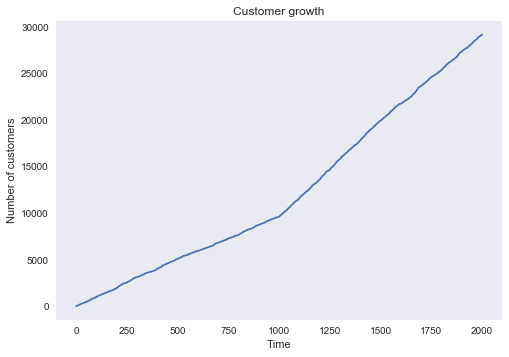

In [383]:
import matplotlib

customers = model.handler.get_customer_growth()

# Data for plotting
x = customers

fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Number of customers',
       title='Customer growth')
ax.grid()

# fig.savefig("Customer_growth.png")
plt.show()

In [384]:
print(model.handler.get_mean_customer_growth())

14.588


In [385]:
print(model.handler.get_mean_handler_load())

5.187


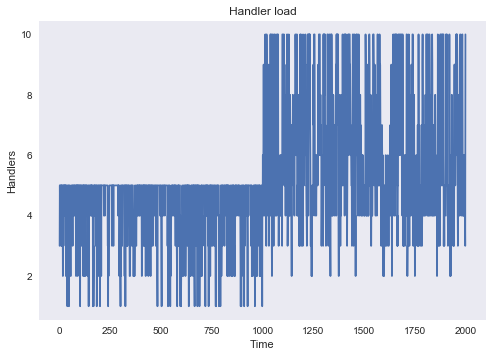

In [387]:
import matplotlib

load = model.handler.get_handler_load()

# Data for plotting
x = load


fig, ax = plt.subplots()

ax.plot(x)

ax.set(xlabel='Time', ylabel='Handlers',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

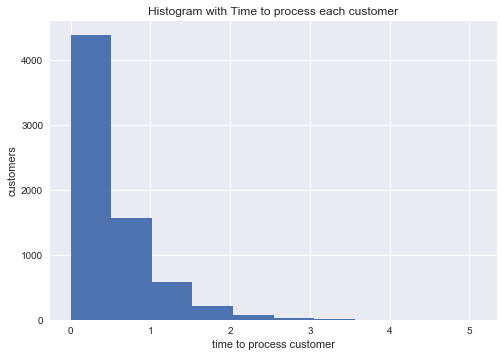

In [356]:
x = model.handler.mean_time_spent

# the histogram of the data
n, bins, patches = plt.hist(x)


plt.xlabel('time to process customer')
plt.ylabel('customers')
plt.title('Histogram with Time to process each customer')

plt.grid(True)
plt.show()

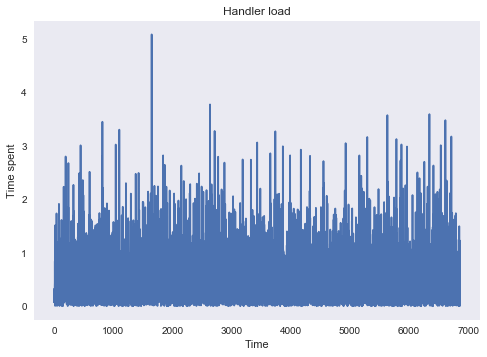

In [357]:
import matplotlib

load = model.handler.mean_time_spent

# Data for plotting
x = load


fig, ax = plt.subplots()
ax.plot(x)

ax.set(xlabel='Time', ylabel='Time spent',
       title='Handler load')
ax.grid()

# fig.savefig("Handler_load.png")
plt.show()

In [358]:
np.mean(model.handler.mean_time_spent)

0.49458450631773504

In [359]:
class Theory:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        self.lambda_ = lambda_
        self.nu = nu

# вероятность, что k обработчиков заняты
    def get_k_handlers_load_probability(self, k):
        traffic=self.lambda_/self.nu
        return (pow(traffic, k)/math.factorial(k))/(sum(pow(traffic,n)/math.factorial(n) for n in range(0, self.number_of_handlers)))

# вероятность отказа
    def get_loss_probability(self):
        return self.get_k_handlers_load_probability(self.number_of_handlers)

# относительная пропускная способность - вероятность, что заявка будет обслужена
    def get_handle_probability(self):
        return 1 - self.get_loss_probability()

# среднее время поступления заявки
    def get_mean_waiting_time(self):
        return self.lambda_

# среднее время обслуживания
    def get_mean_time_spent(self):
        return 1 / self.nu

# абсолютная пропускная способность - среднее число заявок, обслуживаемых в единицу времени
    def absolute_bandwidth(self):
        return self.lambda_ * self.get_handle_probability()

# число покупалетей за все время
    def get_customers_all(self, steps):
        return self.lambda_ * steps

# среднее число занятых касс - интенсивность потока обслуженных системой заявок (в единицу времени)
    def get_mean_handler_load(self):
        return (sum(n * self.get_k_handlers_load_probability(n) for n in range(0, self.number_of_handlers)))
#        return absolute_bandwidth() / self.nu

    def get_number_of_customers_left(self, steps):
        return self.get_customers_all(steps) * self.get_loss_probability()

In [362]:
theory = Theory(5, 10, 2)

In [363]:
theory.get_k_handlers_load_probability(1)

0.07648183556405354

In [364]:
print(theory.get_loss_probability())
print(model.handler.number_of_customers_left / model.handler.customers_all)

0.39834289356277885
0.319294420770984


In [330]:
theory.get_handle_probability()

0.6016571064372211

In [331]:
theory.get_mean_waiting_time()

10

In [332]:
theory.get_mean_time_spent()

0.5

In [333]:
theory.absolute_bandwidth()

6.0165710643722115

In [334]:
theory.get_customers_all(500)

5000

In [335]:
theory.get_mean_handler_load()

3.0082855321861057

In [336]:
theory.get_number_of_customers_left(1000)

3983.4289356277886